In [14]:
import pandas as pd
import numpy as np 
import json
import os
import re

In [15]:
def sorter(column):
    reorder = [
        "Make Public Statement",
        "Consult",
        "Disapprove",
        "Coerce",
        "Engage In Diplomatic Cooperation",
        "Engage In Material Cooperation",
        "Appeal",
        "Fight",
        "Threaten",
        "Yield",
        "Express Intend to Cooperate",        
        "Demand",
        "Provide Aid",
        "Investigate",
        "Assault",
        "Reduce Relations",
        "Protest",
        "Reject",
        "Exhibit Military Posture",
        "Engage In Unconventional Mass Violence"
    ]
    # This also works:
    # mapper = {name: order for order, name in enumerate(reorder)}
    # return column.map(mapper)
    cat = pd.Categorical(column, categories=reorder, ordered=True)
    return pd.Series(cat)

In [16]:
read = pd.read_json("raw/out_label/summaries_outx.json", lines = True)
read_2 = pd.read_json("raw/out_label/counter_annotate.json", lines = True)
df = pd.concat([read, read_2])
data = df[df.answer == "accept"]
data.head()

,text,article_id,_input_hash,_task_hash,_is_binary,spans,tokens,_view_id,relations,answer,_timestamp
0,Ukraine war: Russian tactics on eastern front ...,0,1192826571,1725000051,False,"[{'start': 0, 'end': 7, 'token_start': 0, 'tok...","[{'text': 'Ukraine', 'start': 0, 'end': 7, 'id...",relations,"[{'head': 3, 'child': 0, 'head_span': {'start'...",accept,1666853824
2,Lee Jae-yong: Samsung appoints Lee Jae-yong to...,2,-386898449,495824270,False,"[{'start': 0, 'end': 12, 'token_start': 0, 'to...","[{'text': 'Lee', 'start': 0, 'end': 3, 'id': 0...",relations,"[{'head': 31, 'child': 18, 'head_span': {'star...",accept,1666854104
3,New Zealand Instagram couple 'relieved' after ...,3,94784817,-1047716132,False,"[{'start': 0, 'end': 28, 'token_start': 0, 'to...","[{'text': 'New', 'start': 0, 'end': 3, 'id': 0...",relations,"[{'head': 3, 'child': 9, 'head_span': {'start'...",accept,1666854141
4,Iran protests: Police fire on Mahsa Amini mour...,4,-1204324385,1067222802,False,"[{'start': 0, 'end': 4, 'token_start': 0, 'tok...","[{'text': 'Iran', 'start': 0, 'end': 4, 'id': ...",relations,"[{'head': 3, 'child': 8, 'head_span': {'start'...",accept,1666854246
5,Germany plans to legalise recreational cannabi...,5,1523244431,980527859,False,"[{'start': 0, 'end': 7, 'token_start': 0, 'tok...","[{'text': 'Germany', 'start': 0, 'end': 7, 'id...",relations,"[{'head': 0, 'child': 5, 'head_span': {'start'...",accept,1666854286


In [17]:
data.shape

(1151, 11)

In [18]:
def preprocess_raw(df):
    #get data into needed format and create new DataFrame
    data = []
    for index,row in df.iterrows():
        rel_list = []
        for rel in row.relations:
            subj = row.text[rel["head_span"]["start"]:rel["head_span"]["end"]]
            obj = row.text[rel["child_span"]["start"]:rel["child_span"]["end"]]
            rel_list.append(f"<triplet> {subj} <subj> {obj} <obj> {rel['label']}")
        data.append({"doc_id":row.article_id, "text": row.text, "triplets": " ".join(rel_list)})

    data = pd.DataFrame(data, columns = ["doc_id","text","triplets"])
    data = data[data.triplets != ""]
    data["rel_count"] = data.triplets.apply(lambda x: x.count("<triplet>"))
    return data

In [19]:
data = preprocess_raw(data)

In [20]:
d = "<triplet>"
len_list = []
trip_list = []
for triplet in data.triplets.to_list():
    s =  [d+e.rstrip() for e in triplet.split(d) if e]
    trip_list.append(s)
    len_list.append(len(s))

In [21]:
data["len"] = len_list

In [22]:
#Remove duplicates from labels?
dedupe = [list(set(x)) for x in trip_list]
new_len = [len(list(set(x))) for x in trip_list]
data["new_len"] = new_len

In [23]:
#Number of rows where relations need to be deduped
data[data.len != data.new_len].shape

(132, 6)

In [24]:
data["triplets"] = data.triplets.apply(lambda x: x.replace(
    "ProvideAid", "Provide Aid").replace(
    "EngageInDiplomaticCooperation", "Engage In Diplomatic Cooperation").replace(
    "MakePublicStatement", "Make Public Statement").replace(
    "ExpressIntendToCooperate","Express Intend to Cooperate").replace(
    "EngageInMaterialCooperation","Engage In Material Cooperation").replace(
    "ExhibitMilitaryPosture","Exhibit Military Posture").replace(
    "ReduceRelations", "Reduce Relations").replace(
    "ExpressIntentToCooperate", "Express Intent to Cooperate").replace(
    "EngageInUnconventialMassViolence", "Engage in unconventional mass violence"))

In [25]:
d = "<triplet>"
len_list = []
trip_list = []
for triplet in data.triplets.to_list():
    s =  [d+e.rstrip() for e in triplet.split(d) if e]
    trip_list.append(s)
    len_list.append(len(s))

In [26]:
data["in_len"] = data.text.apply(lambda x: len(x))

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:

#extract the categorized relation for stratified split on cameo codes
relation = []
len_cat = []
for row in data.iterrows():
    rel_iter = row[1]["triplets"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <triplet>)", rel_iter)
    relation.append(all_rels)
data["relations"] = relation
data["rel_len"] = data.relations.apply(lambda x: len(x))

In [30]:
expl = data.explode("relations")

In [31]:
expl.relations.to_list().count("Make Public Statement")/expl.shape[0]
#34.27% relations are Public statements

0.338082517067379

In [32]:
expl[(expl.relations == "Make Public Statement") & (expl.rel_len == 1)].shape

(54, 9)

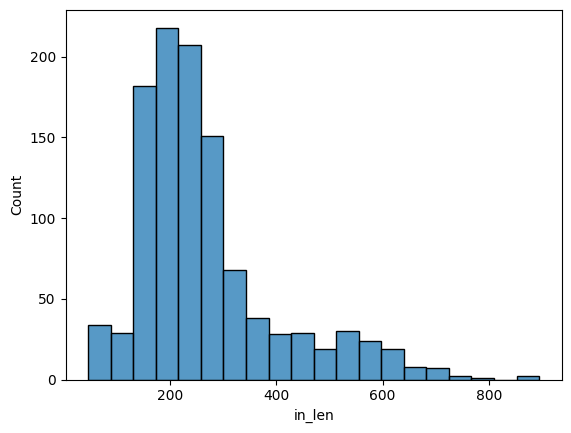

(180.0, 232.0, 302.25)

In [33]:
sns.histplot(data.in_len, bins = 20)
plt.show()
np.percentile(data.in_len, 25), np.percentile(data.in_len, 50), np.percentile(data.in_len, 75)

Text(0.5, 0, 'Label')

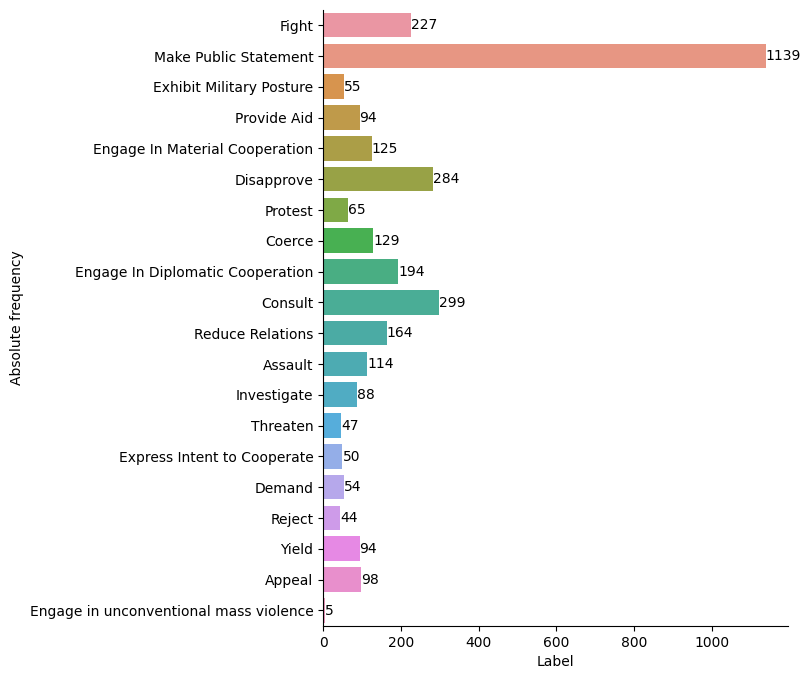

In [34]:
plt.figure(figsize=(6,8))
ax = sns.countplot(y = expl.relations)
ax.bar_label(ax.containers[0])
sns.despine()
plt.ylabel('Absolute frequency')
plt.xlabel('Label')
#this dataset also needs augmentation!

In [35]:
data.shape[0]

1096

In [36]:
#How many relations does each text have?
data["rel_count"] = data.triplets.apply(lambda x: x.count("<triplet>"))
for count in range(data.rel_count.max()):
    print(f"Count of sentences with {count + 1} relations: {data[data.rel_count == count + 1].shape[0]} ({data[data.rel_count == count + 1].shape[0]/data.shape[0]}%)")

#all sentences have only 1 relation

Count of sentences with 1 relations: 224 (0.20437956204379562%)
Count of sentences with 2 relations: 289 (0.2636861313868613%)
Count of sentences with 3 relations: 223 (0.20346715328467152%)
Count of sentences with 4 relations: 154 (0.14051094890510948%)
Count of sentences with 5 relations: 72 (0.06569343065693431%)
Count of sentences with 6 relations: 68 (0.06204379562043796%)
Count of sentences with 7 relations: 33 (0.030109489051094892%)
Count of sentences with 8 relations: 21 (0.01916058394160584%)
Count of sentences with 9 relations: 8 (0.0072992700729927005%)
Count of sentences with 10 relations: 1 (0.0009124087591240876%)
Count of sentences with 11 relations: 3 (0.002737226277372263%)


In [24]:
data.to_csv("annotated_data_noaug.csv")

## Create splits

In [56]:
full = pd.read_csv("annotated/sent_full.csv")
cameo = pd.read_csv("annotated/CAMEO.csv")[["text","triplets"]]
cameo.columns = ["text","label"]

cameo["label"] = cameo.label.apply(lambda x: x.replace("Express Intent to Cooperate","Express Intend to Cooperate"))

In [57]:
relation = []
for row in cameo.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <triplet>)", rel_iter)
    relation.append(all_rels)
cameo["relations"] = relation

cameo["mps"] = cameo.relations.apply(lambda x: x.count("Make Public Statement"))
cameo["len"] = cameo.relations.apply(lambda x: len(x))
mps = []
for row in cameo.iterrows():
    mps.append(row[1]["mps"] / row[1]["len"])
cameo["MPS%"] = mps

In [58]:
mps = cameo[(cameo["MPS%"] > 0.6) & (cameo.mps > 1)]

In [59]:
cameo["unq"] = cameo.relations.apply(lambda x: len(list(set(x))))

In [60]:
new_sub=[]
for row in mps.iterrows():

    try:
        ex = row[1]["text"]

        rm = ex[ex.rindex(',')+1:]
        label = row[1]["label"]

        remainder = ex[:-(len(ex[ex.rindex(','):]))]

        rels = []
        split = re.split("<\w*>", label)[1:] #first one is empty
        for i in range(int(len(split)/3)): #always pairs of 3
            sub = split[i*3:i*3+3]
            rels.append([sub[0].lstrip().rstrip(), sub[1].lstrip().rstrip(), sub[2].lstrip().rstrip()])
        
        keep = []
        for rel in rels:
            if rel[2] == "Make Public Statement":

                if rel[0] in rm or rel[1] in rm:
                    #print(rel)
                    continue
                else: 
                    keep.append(rel)
            else: keep.append(rel)
        
        new_rel = ""
        for rel in keep:
            new_rel += f"<triplet> {rel[0]} <subj> {rel[1]} <obj> {rel[2]} "
        new_sub.append([remainder,new_rel.rstrip()])

    except:
        new_sub.append([row[1]["text"], row[1]["label"]])


In [61]:
cameo = cameo.drop(index = mps.index)
new = pd.DataFrame(new_sub, columns = ["text","label"])
cameo = pd.concat([cameo, new]).reset_index().drop(columns = ["index"])[["text","label"]]

In [ ]:
relation = []
for row in cameo.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <triplet>)", rel_iter)
    relation.append(all_rels)
cameo["relations"] = relation

cameo["len"] = cameo.relations.apply(lambda x: len(x))
cameo["post"] = cameo.relations.apply(lambda x: "Exhibit Military Posture" in x) #since only few labels, all go to test
post = cameo[cameo.post == True]
cameo = cameo[cameo.post == False]

for row in cameo.iterrows():
    row[1]["relations"].append(str(row[1]["len"])+".")

data = cameo.copy()

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

mlb = MultiLabelBinarizer()
accept_MLB = mlb.fit_transform(data["relations"])

cols = [f"rel{i}" for i in range(len(accept_MLB[0]))]
data2 = pd.concat([data.reset_index(), pd.DataFrame(accept_MLB, columns = cols)], axis = 1)

#select indexes for train & val
splits = MultilabelStratifiedShuffleSplit(test_size=round(len(data2.text) * 0.4), train_size= (len(data2.text) - round(len(data2.text) * 0.4)), random_state = 0)
test_idx, val_idx = next(splits.split(data2.text, data2[cols]))

pre_split = data2.iloc[val_idx]

splits = MultilabelStratifiedShuffleSplit(test_size=round(len(pre_split.text) * 0.5), train_size= (len(pre_split.text) - round(len(pre_split.text) * 0.5)), random_state = 0)
#0,4 works decent
val_idx, train_idx = next(splits.split(pre_split.text, pre_split[cols]))

test = data2.iloc[test_idx]
val = pre_split.iloc[val_idx] #pre_split
train = pre_split.iloc[train_idx]

train_cam = train[["text","label"]]
val_cam = val[["text","label"]]
test = test[["text","label"]]
test = pd.concat([test, post[["text","label"]]])

print("train shape", train_cam.shape)
print("val shape", val_cam.shape)
print("test shape", test.shape)

In [ ]:
relation = []
for row in test.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <triplet>)", rel_iter)
    relation.append(all_rels)
test["relations"] = relation
test.explode("relations").groupby("relations").text.count()
test.to_csv("annotated_noaug/test_2.csv")

In [ ]:
relation = []
for row in full.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <triplet>)", rel_iter)
    relation.append(all_rels)
full["relations"] = relation
full["len"] = full.relations.apply(lambda x: len(x))

idx = []
for row in full.iterrows():
    if "Engage in unconventional mass violence" in row[1]["relations"]: idx.append(row[0])
#Drop unconventional mass violence because not represented 
full = full.drop(index = idx).reset_index().drop(columns = ["index"])
full = full.reset_index().drop(columns = ["index"])

for row in full.iterrows():
    row[1]["relations"].append(str(row[1]["len"])+".")

data = full.copy()

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

mlb = MultiLabelBinarizer()
accept_MLB = mlb.fit_transform(data["relations"])

cols = [f"rel{i}" for i in range(len(accept_MLB[0]))]
data2 = pd.concat([data.reset_index(), pd.DataFrame(accept_MLB, columns = cols)], axis = 1)

#select indexes for train & val
splits = MultilabelStratifiedShuffleSplit(test_size=round(len(data2.text) * 0.9), train_size= (len(data2.text) - round(len(data2.text) * 0.9)), random_state = 2)
val_idx, train_idx = next(splits.split(data2.text, data2[cols]))

val = data2.iloc[val_idx]
train = data2.iloc[train_idx]

train = train[["text","label"]]
train = pd.concat([train, train_cam])
val = val[["text","label"]]
val = pd.concat([val, val_cam])


print("train shape", train.shape)
print("val shape", val.shape)
print("test shape", test.shape) #from CAMEO

In [ ]:
train.to_csv("annotated_noaug/train_2.csv")
val.to_csv("annotated_noaug/val_2.csv")

In [ ]:
#next step is augmenting this data with DataAugmentationAnnotated.py

## EDA on augmented data

In [37]:
cameo_to_penta = {
    "Make Public Statement" : "Make a Statement",
    "Appeal" : "Make a Statement", 
    "Express Intend to Cooperate" : "Verbal Cooperation",
    "Express Intent to Cooperate" : "Verbal Cooperation",
    "Consult" : "Verbal Cooperation",
    "Engage In Diplomatic Cooperation" : "Verbal Cooperation",
    "Engage In Material Cooperation" : "Material Cooperation",
    "Provide Aid" : "Material Cooperation",
    "Yield" : "Material Cooperation", 
    "Investigate" : "Verbal Conflict",
    "Demand" : "Verbal Conflict",
    "Disapprove" : "Verbal Conflict",
    "Reject" : "Verbal Conflict",
    "Threaten" : "Verbal Conflict",
    "Exhibit Military Posture" : "Material Conflict",
    "Protest" : "Material Conflict", 
    "Reduce Relations" : "Verbal Conflict",
    "Coerce" : "Material Conflict",
    "Assault" : "Material Conflict",
    "Fight" : "Material Conflict",
    "Engage in unconventional mass violence" : "Material Conflict"
}

In [38]:
def remove_duplicate_labels(df):
    new = []
    for row in df.iterrows():

        try:
            ex = row[1]["label"]     
        except: 
            ex = row[1]["triplets"]

        cur_subj = ""
        cur_obj = ""
        cur_rel = ""
        c = 0

        new_rel = []
        for part in re.split(r"\s(?=<\w*>)", ex.lstrip()):
            if re.findall("<\w+>", part)[0] == "<triplet>":
                cur_subj = part.replace("<triplet> ","")
            elif re.findall("<\w+>", part)[0] == "<subj>":
                cur_obj = part.replace("<subj> ","")
                c+=1
            elif re.findall("<\w+>", part)[0] == "<obj>":
                cur_rel = part.replace("<obj> ","")
                c+=1
            if c == 2:
                new_rel.append(f"<triplet> {cur_subj} <subj> {cur_obj} <obj> {cur_rel}")
                c = 0

        new_rel = list(set(new_rel))
        sub_dedupe = " ".join(new_rel)
        new.append(sub_dedupe)         
            
    df["label"] = new
    return df[["text","label"]]

In [42]:
data_rdy = pd.read_csv("annotated/sent_full.csv", index_col= 0)
data_rdy["split"] = "original"
#train and validation data from DataAugementation.ipynb

train = pd.read_csv("annotated/new_train_aug_0.csv", index_col= 0)
train["split"] = "training"
val = pd.read_csv("annotated/new_val_aug_0.csv", index_col= 0)
val["split"] = "validation"
test = pd.read_csv("annotated/new_test_aug_0.csv", index_col= 0)
test["split"] = "test"

full_set = pd.concat([train, val, test])

data_rdy.shape, train.shape, val.shape, test.shape, full_set.shape

((1769, 3), (2577, 3), (251, 3), (224, 3), (3052, 3))

# Inter Annotator Agreement

(Big Shoutouts to Felix!)

In [44]:
import spacy
nlp = spacy.load("en_core_web_trf")

In [45]:
def annot_to_sent(df):
    new = []
    for index, row in df.iterrows():
        doc = nlp(row.text)
        splits = []
        cur_sent = ""
        last_end = True
        start_idx = 0
        last_idx = 0

        for sent in doc.sents:
            sent = sent.text
            last_idx = start_idx + len(sent)
            splits.append([start_idx,last_idx, sent])
            start_idx += len(cur_sent + sent) + 1

            relations = row.relations.copy()
            for i in range(len(splits)):
                sub = splits.pop(0)

                start = sub[0]
                lim = sub[1]
                text = sub[2]

                for idx, rel in enumerate(relations):
                    if rel["head_span"]["end"] <= lim and rel["child_span"]["end"] <= lim and rel["head_span"]["start"] >= start and rel["child_span"]["start"] >= start:
                        subj = text[rel["head_span"]["start"]-start:rel["head_span"]["end"]-start]
                        obj = text[rel["child_span"]["start"]-start:rel["child_span"]["end"]-start]
                        new.append([text, f"<triplet> {subj} <subj> {obj} <obj> {rel['label']}", row.article_id])
                        relations[idx] == [9999,9999,"found already"]

    last_txt = ""
    last_rel = ""
    alligned = []
    for sent in new:
        if sent[0] == last_txt:
            last_rel = last_rel.lstrip() + " " + sent[1]
        elif sent[0] != last_txt:
            alligned.append([last_txt, last_rel, sent[2]])
            last_txt = sent[0]
            last_rel = sent[1]
    if alligned[-1][0] == last_txt:
        alligned[-1][1] == alligned[-1][1] + " " + sent[1]
    else:
        alligned.append([last_txt, last_rel, sent[2]])
    alligned.pop(0)

    df = pd.DataFrame(alligned, columns = ["text","triplets","doc_id"])
    return df

In [46]:
read = pd.read_json("raw/out_label/summaries_felix.json", lines = True)
df_f = read[read.answer == "accept"]
df_f.head()

,text,article_id,_input_hash,_task_hash,_is_binary,spans,tokens,_view_id,relations,answer,_timestamp
0,"Sensible America finally spoke, but ‘Trumpty D...",3159,2108892512,770305806,False,"[{'start': 0, 'end': 16, 'token_start': 0, 'to...","[{'text': 'Sensible', 'start': 0, 'end': 8, 'i...",relations,"[{'head': 17, 'child': 22, 'head_span': {'star...",accept,1672048142
1,How Was Russia Able to Launch Russia's Biggest...,4317,-1406124216,-723512353,False,"[{'start': 8, 'end': 14, 'token_start': 2, 'to...","[{'text': 'How', 'start': 0, 'end': 3, 'id': 0...",relations,"[{'head': 2, 'child': 12, 'head_span': {'start...",accept,1672048306
2,World leaders discuss climate change solutions...,2396,-2130737925,1317932275,False,"[{'start': 0, 'end': 13, 'token_start': 0, 'to...","[{'text': 'World', 'start': 0, 'end': 5, 'id':...",relations,"[{'head': 1, 'child': 7, 'head_span': {'start'...",accept,1672048623
3,"In Colombia, Drilling Pays the Bills. Colombia...",3831,-534305385,-1860660404,False,"[{'start': 3, 'end': 11, 'token_start': 1, 'to...","[{'text': 'In', 'start': 0, 'end': 2, 'id': 0,...",relations,"[{'head': 9, 'child': 13, 'head_span': {'start...",accept,1672048776
4,Photo: Mohamed Salah shares image of Mohamed S...,1188,343647075,791917291,False,"[{'start': 7, 'end': 20, 'token_start': 2, 'to...","[{'text': 'Photo', 'start': 0, 'end': 5, 'id':...",relations,"[{'head': 51, 'child': 46, 'head_span': {'star...",accept,1672049094


In [47]:
df_sent = annot_to_sent(df_f)

In [48]:
df_sent.shape

(123, 3)

In [49]:
read = pd.read_json("raw/out_label/counter_annotate.json", lines = True)
df_c = read[read.answer == "accept"]
df_c.head()

,text,article_id,_input_hash,_task_hash,_is_binary,spans,tokens,_view_id,relations,answer,_timestamp
0,"Sensible America finally spoke, but ‘Trumpty D...",3159,2108892512,770305806,False,"[{'start': 68, 'end': 89, 'token_start': 15, '...","[{'text': 'Sensible', 'start': 0, 'end': 8, 'i...",relations,"[{'head': 17, 'child': 22, 'head_span': {'star...",accept,1672333765
1,How Was Russia Able to Launch Russia's Biggest...,4317,-1406124216,-723512353,False,"[{'start': 8, 'end': 14, 'token_start': 2, 'to...","[{'text': 'How', 'start': 0, 'end': 3, 'id': 0...",relations,"[{'head': 18, 'child': 21, 'head_span': {'star...",accept,1672333840
2,World leaders discuss climate change solutions...,2396,-2130737925,1317932275,False,"[{'start': 0, 'end': 13, 'token_start': 0, 'to...","[{'text': 'World', 'start': 0, 'end': 5, 'id':...",relations,"[{'head': 1, 'child': 7, 'head_span': {'start'...",accept,1672333863
3,"In Colombia, Drilling Pays the Bills. Colombia...",3831,-534305385,-1860660404,False,"[{'start': 38, 'end': 54, 'token_start': 8, 't...","[{'text': 'In', 'start': 0, 'end': 2, 'id': 0,...",relations,"[{'head': 9, 'child': 13, 'head_span': {'start...",accept,1672333943
4,Photo: Mohamed Salah shares image of Mohamed S...,1188,343647075,791917291,False,"[{'start': 7, 'end': 20, 'token_start': 2, 'to...","[{'text': 'Photo', 'start': 0, 'end': 5, 'id':...",relations,"[{'head': 51, 'child': 46, 'head_span': {'star...",accept,1672049094


In [50]:
df_fe = preprocess_raw(df_f)
df_co = preprocess_raw(df_c)

In [51]:
df_fe.shape, df_co.shape

((73, 4), (73, 4))

In [52]:
new = []
for row in df_fe.iterrows():

    split = re.split("<\w*>", row[1]["triplets"])[1:]       #first one is empty
    for i in range(int(len(split)/3)):                      #always pairs of 3
        sub_split = split[i*3:i*3+3]
        sub_split = [sub.rstrip().lstrip() for sub in sub_split]
        if [row[1]["doc_id"], sub_split,
         [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()],
          sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()] not in new: #remove duplicate triplets
            new.append([row[1]["doc_id"], sub_split, [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()], 
            sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()])         
        
df_fel = pd.DataFrame(new, columns = ["id","split", "ents", "subj", "obj", "rels"])

In [53]:
new = []
for row in df_co.iterrows():

    split = re.split("<\w*>", row[1]["triplets"])[1:]       #first one is empty
    for i in range(int(len(split)/3)):                      #always pairs of 3
        sub_split = split[i*3:i*3+3]
        sub_split = [sub.rstrip().lstrip() for sub in sub_split]
        if [row[1]["doc_id"], sub_split,
         [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()],
          sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()] not in new: #remove duplicate triplets
            new.append([row[1]["doc_id"], sub_split, [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()], 
            sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()])            
        
df_cou = pd.DataFrame(new, columns = ["id","split", "ents", "subj", "obj", "rels"])

In [54]:
df_fel.shape, df_cou.shape

((231, 6), (213, 6))

In [55]:
#check if the two sets contain exactly same articles
df_cou.id.unique() == df_fel.id.unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [56]:
#agreement for entities
tp = 0
fp = 0
fn = 0
exact = []
for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    for row in df_f_id.iterrows():
        if row[1]["ents"] in df_c_id.ents.to_list():
            tp += 1
            exact.append([row[1]["subj"], row[1]["obj"]])
        else:
            fp += 1
    fn = df_cou.shape[0] - tp

In [57]:
tp, fp, fn

(153, 78, 60)

In [58]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.6623376623376623, 0.7183098591549296, 0.6891891891891893)

In [59]:
#relaxed agreement for entities
tp = len(exact)
c = 0
tp_1 = 0
tp_2 = 0
fp = 0
fn = 0
found_l = []

found_l_3 = []

for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    sub = df_c_id.copy().reset_index()
    for row in df_f_id.iterrows():
        if row[1]["subj"] in df_c_id.subj.to_list():
            sub["relevant"] = sub.subj.apply(lambda x: row[1]["subj"] in x)
            rel = sub[sub.relevant == True]
            found = 0
            for idx, obj in enumerate(rel.obj.to_list()):
                if row[1]["obj"] in obj and [row[1]["subj"],row[1]["obj"], rel.subj.iloc[idx], obj] not in found_l:
                    if [row[1]["subj"], row[1]["obj"]] not in exact:
                        tp_1 += 1
                        found += 1

                        found_l.append([row[1]["subj"],row[1]["obj"], rel.subj.iloc[idx], obj])
                        found_l.append([rel.subj.iloc[idx], obj, row[1]["subj"],row[1]["obj"]])

                        found_l_3.append([[row[1]["subj"],row[1]["obj"],row[1]["rels"]],[rel.subj.iloc[idx], obj, rel["rels"].iloc[idx]]])
                    break


found_l_2 = []

for id in df_cou.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    sub = df_f_id.copy().reset_index()
    for row in df_c_id.iterrows():
        if row[1]["subj"] in df_f_id.subj.to_list():
            sub["relevant"] = sub.subj.apply(lambda x: row[1]["subj"] in x)
            rel = sub[sub.relevant == True]
            found = 0
            for idx, obj in enumerate(rel.obj.to_list()):
                if row[1]["obj"] in obj and [row[1]["subj"],row[1]["obj"], rel.subj.iloc[idx], obj] not in found_l:
                    if [row[1]["subj"], row[1]["obj"]] not in exact:
                        tp_2 += 1
                        found += 1
            
                        found_l_2.append([[row[1]["subj"],row[1]["obj"],row[1]["rels"]],[rel.subj.iloc[idx], obj, rel["rels"].iloc[idx]]])
                    break

fp = df_fel.shape[0] - (tp + tp_1) - tp_2
fn = df_cou.shape[0] - (tp + tp_2) - tp_1
tp = tp + tp_1 + tp_2

In [60]:
tp, fp, fn
#156, 136

(175, 56, 38)

In [61]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.7575757575757576, 0.8215962441314554, 0.7882882882882883)

In [62]:
import collections

In [63]:
#agreement for relation classification
#with found relations in sentence -> overlap
tp = 0
fp = 0
fn = 0

for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id].rels
    df_c_id = df_cou[df_cou.id == id].rels

    f = collections.Counter(df_f_id.to_list())
    c = collections.Counter(df_c_id.to_list())

    tp += len(list((f & c).elements()))
    fp += len(list((f - c).elements()))
    fn += len(list((c - f).elements()))

In [64]:
tp, fp, fn

(168, 63, 45)

In [65]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.7272727272727273, 0.7887323943661971, 0.7567567567567568)

In [66]:
#agreement for full relations
tp = 0
fp = 0
fn = 0

fix_list = []
good_list = []
for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    for row in df_f_id.iterrows():
        if row[1]["split"] in df_c_id.split.to_list():
            tp += 1
            #good_list.append([row[1]["id"], row[1]["split"]])
        else:
            fp += 1
            fix_list.append([row[1]["id"], row[1]["split"]])
    for row in df_c_id.iterrows():
        if row[1]["split"] not in df_f_id.split.to_list():
            fn += 1

In [67]:
tp, fp, fn

(137, 94, 76)

In [68]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.5930735930735931, 0.6431924882629108, 0.617117117117117)

In [69]:
#agreement for relation with relaxed entities
tp_exact = tp #exact matches
tp_1 = 0
tp_2 = 0

for row in found_l_3:       #taken from fuzzy entity matches
    if row[0][2] == row[1][2]:
        tp_1 += 1
for row in found_l_2:
    if row[0][2] == row[1][2]:
        tp_2 += 1

tp_rel = tp_exact + tp_1 + tp_2
fp = df_fel.shape[0] - (tp + tp_1) - tp_2
fn = df_cou.shape[0] - (tp + tp_2) - tp_1

In [70]:
tp, tp_1, tp_2, fp, fn, tp_rel

(137, 9, 7, 78, 60, 153)

In [71]:
precision = tp_rel / (fp + tp_rel)
recall = tp_rel / (fn + tp_rel)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.6623376623376623, 0.7183098591549296, 0.6891891891891893)

IAA Pentacode

In [98]:
df_fe = preprocess_raw(df_f)
df_co = preprocess_raw(df_c)

In [99]:
df_fe["triplets"] = df_fe.triplets.apply(lambda x: x.replace(
    "ProvideAid", "Provide Aid").replace(
    "EngageInDiplomaticCooperation", "Engage In Diplomatic Cooperation").replace(
    "MakePublicStatement", "Make Public Statement").replace(
    "ExpressIntendToCooperate","Express Intend to Cooperate").replace(
    "EngageInMaterialCooperation","Engage In Material Cooperation").replace(
    "ExhibitMilitaryPosture","Exhibit Military Posture").replace(
    "ReduceRelations", "Reduce Relations").replace(
    "ExpressIntentToCooperate", "Express Intend to Cooperate").replace(
    "EngageInUnconventialMassViolence", "Engage in unconventional mass violence"))

df_co["triplets"] = df_co.triplets.apply(lambda x: x.replace(
    "ProvideAid", "Provide Aid").replace(
    "EngageInDiplomaticCooperation", "Engage In Diplomatic Cooperation").replace(
    "MakePublicStatement", "Make Public Statement").replace(
    "ExpressIntendToCooperate","Express Intend to Cooperate").replace(
    "EngageInMaterialCooperation","Engage In Material Cooperation").replace(
    "ExhibitMilitaryPosture","Exhibit Military Posture").replace(
    "ReduceRelations", "Reduce Relations").replace(
    "ExpressIntentToCooperate", "Express Intend to Cooperate").replace(
    "EngageInUnconventialMassViolence", "Engage in unconventional mass violence"))

In [100]:
penta_map = []
for row in df_fe.iterrows():
    trip_text = row[1]["triplets"]
    for key in cameo_to_penta.keys():
        if key in row[1]["triplets"]: trip_text = trip_text.replace(key, cameo_to_penta[key])
    penta_map.append([row[1]["text"], trip_text, row[1]["doc_id"]])
df_fe = pd.DataFrame(penta_map, columns = ["text","triplets","doc_id"])

penta_map = []
for row in df_co.iterrows():
    trip_text = row[1]["triplets"]
    for key in cameo_to_penta.keys():
        if key in row[1]["triplets"]: trip_text = trip_text.replace(key, cameo_to_penta[key])
    penta_map.append([row[1]["text"], trip_text, row[1]["doc_id"]])
df_co = pd.DataFrame(penta_map, columns = ["text","triplets","doc_id"])

In [101]:
df_fe.shape, df_co.shape

((73, 3), (73, 3))

In [102]:
new = []
for row in df_fe.iterrows():

    split = re.split("<\w*>", row[1]["triplets"])[1:]       #first one is empty
    for i in range(int(len(split)/3)):                      #always pairs of 3
        sub_split = split[i*3:i*3+3]
        sub_split = [sub.rstrip().lstrip() for sub in sub_split]
        if [row[1]["doc_id"], sub_split,
         [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()],
          sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()] not in new: #remove duplicate triplets
            new.append([row[1]["doc_id"], sub_split, [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()], 
            sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()])         
        
df_fel = pd.DataFrame(new, columns = ["id","split", "ents", "subj", "obj", "rels"])

In [103]:
new = []
for row in df_co.iterrows():

    split = re.split("<\w*>", row[1]["triplets"])[1:]       #first one is empty
    for i in range(int(len(split)/3)):                      #always pairs of 3
        sub_split = split[i*3:i*3+3]
        sub_split = [sub.rstrip().lstrip() for sub in sub_split]
        if [row[1]["doc_id"], sub_split,
         [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()],
          sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()] not in new: #remove duplicate triplets
            new.append([row[1]["doc_id"], sub_split, [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()], 
            sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()])            
        
df_cou = pd.DataFrame(new, columns = ["id","split", "ents", "subj", "obj", "rels"])

In [104]:
df_fel.shape, df_cou.shape

((231, 6), (213, 6))

In [106]:
#check if the two sets contain exactly same articles
df_cou.id.unique() == df_fel.id.unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [107]:
#agreement for entities
tp = 0
fp = 0
fn = 0
exact = []
for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    for row in df_f_id.iterrows():
        if row[1]["ents"] in df_c_id.ents.to_list():
            tp += 1
            exact.append([row[1]["subj"], row[1]["obj"]])
        else:
            fp += 1
    fn = df_cou.shape[0] - tp

In [108]:
tp, fp, fn

(153, 78, 60)

In [109]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.6623376623376623, 0.7183098591549296, 0.6891891891891893)

In [110]:
#relaxed agreement for entities
tp = len(exact)
c = 0
tp_1 = 0
tp_2 = 0
fp = 0
fn = 0
found_l = []

found_l_3 = []

for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    sub = df_c_id.copy().reset_index()
    for row in df_f_id.iterrows():
        if row[1]["subj"] in df_c_id.subj.to_list():
            sub["relevant"] = sub.subj.apply(lambda x: row[1]["subj"] in x)
            rel = sub[sub.relevant == True]
            found = 0
            for idx, obj in enumerate(rel.obj.to_list()):
                if row[1]["obj"] in obj and [row[1]["subj"],row[1]["obj"], rel.subj.iloc[idx], obj] not in found_l:
                    if [row[1]["subj"], row[1]["obj"]] not in exact:
                        tp_1 += 1
                        found += 1

                        found_l.append([row[1]["subj"],row[1]["obj"], rel.subj.iloc[idx], obj])
                        found_l.append([rel.subj.iloc[idx], obj, row[1]["subj"],row[1]["obj"]])

                        found_l_3.append([[row[1]["subj"],row[1]["obj"],row[1]["rels"]],[rel.subj.iloc[idx], obj, rel["rels"].iloc[idx]]])
                    break


found_l_2 = []

for id in df_cou.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    sub = df_f_id.copy().reset_index()
    for row in df_c_id.iterrows():
        if row[1]["subj"] in df_f_id.subj.to_list():
            sub["relevant"] = sub.subj.apply(lambda x: row[1]["subj"] in x)
            rel = sub[sub.relevant == True]
            found = 0
            for idx, obj in enumerate(rel.obj.to_list()):
                if row[1]["obj"] in obj and [row[1]["subj"],row[1]["obj"], rel.subj.iloc[idx], obj] not in found_l:
                    if [row[1]["subj"], row[1]["obj"]] not in exact:
                        tp_2 += 1
                        found += 1
            
                        found_l_2.append([[row[1]["subj"],row[1]["obj"],row[1]["rels"]],[rel.subj.iloc[idx], obj, rel["rels"].iloc[idx]]])
                    break

fp = df_fel.shape[0] - (tp + tp_1) - tp_2
fn = df_cou.shape[0] - (tp + tp_2) - tp_1
tp = tp + tp_1 + tp_2

In [112]:
tp, fp, fn
#156, 136

(175, 56, 38)

In [113]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.7575757575757576, 0.8215962441314554, 0.7882882882882883)

In [114]:
import collections

In [115]:
#agreement for relation classification
#with found relations in sentence -> overlap
tp = 0
fp = 0
fn = 0

for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id].rels
    df_c_id = df_cou[df_cou.id == id].rels

    f = collections.Counter(df_f_id.to_list())
    c = collections.Counter(df_c_id.to_list())

    tp += len(list((f & c).elements()))
    fp += len(list((f - c).elements()))
    fn += len(list((c - f).elements()))

In [116]:
tp, fp, fn

(182, 49, 31)

In [117]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.7878787878787878, 0.8544600938967136, 0.8198198198198197)

In [118]:
#agreement for full relations
tp = 0
fp = 0
fn = 0

fix_list = []
good_list = []
for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    for row in df_f_id.iterrows():
        if row[1]["split"] in df_c_id.split.to_list():
            tp += 1
            #good_list.append([row[1]["id"], row[1]["split"]])
        else:
            fp += 1
            fix_list.append([row[1]["id"], row[1]["split"]])
    for row in df_c_id.iterrows():
        if row[1]["split"] not in df_f_id.split.to_list():
            fn += 1

In [119]:
tp, fp, fn

(146, 85, 67)

In [120]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.6320346320346321, 0.6854460093896714, 0.6576576576576577)

In [121]:
#agreement for relation with relaxed entities
tp_exact = tp #exact matches
tp_1 = 0
tp_2 = 0

for row in found_l_3:       #taken from fuzzy entity matches
    if row[0][2] == row[1][2]:
        tp_1 += 1
for row in found_l_2:
    if row[0][2] == row[1][2]:
        tp_2 += 1

tp_rel = tp_exact + tp_1 + tp_2
fp = df_fel.shape[0] - (tp + tp_1) - tp_2
fn = df_cou.shape[0] - (tp + tp_2) - tp_1

In [122]:
tp, tp_1, tp_2, fp, fn, tp_rel

(146, 10, 8, 67, 49, 164)

In [123]:
precision = tp_rel / (fp + tp_rel)
recall = tp_rel / (fn + tp_rel)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.70995670995671, 0.7699530516431925, 0.7387387387387389)

: 

### Pre- & Post-Plots

In [4]:
data = pd.read_csv("annotated/sent_full.csv", index_col= 0)
cameo = pd.read_csv("annotated/CAMEO.csv", index_col = 0)[["text", "triplets"]]
cameo.columns = ["text","label"]
data_rdy = pd.concat([data, cameo])
data_rdy["split"] = "original"
#train and validation data from DataAugementation.ipynb

train = pd.read_csv("annotated/new_train_aug_0.csv", index_col = 0)
train["split"] = "training"
val = pd.read_csv("annotated/new_val_aug_0.csv", index_col= 0)
val["split"] = "validation"
test = pd.read_csv("annotated/new_test_aug_0.csv", index_col= 0)
test["split"] = "test"

full_set = pd.concat([train, val, test])

data_rdy.shape, cameo.shape, train.shape, train.shape, val.shape, test.shape, full_set.shape

((2141, 3), (372, 2), (2577, 3), (2577, 3), (251, 3), (224, 3), (3052, 3))

In [5]:
from gensim.parsing.preprocessing import strip_multiple_whitespaces
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

In [7]:
order_1 = {
        "Make Public \nStatement":0,
        "Consult":3,
        "Disapprove":10,
        "Coerce":16,
        "Engage In \nDiplomatic \nCooperation":4,
        "Engage In \nMaterial \nCooperation":6,
        "Appeal":1,
        "Fight":18,
        "Threaten":12,
        "Yield":7,
        "Express Intend\nto Cooperate":2,        
        "Demand":9,
        "Provide Aid":5,
        "Investigate":8,
        "Assault":17,
        "Reduce \nRelations":15,
        "Protest":14,
        "Reject":11,
        "Exhibit \nMilitary \nPosture":13,
        "Engage In \nUnconventional \nMass Violence":19
}

order_2 = {
    "original":0,
    "training":1,
    "validation":2,
    "test":3
}

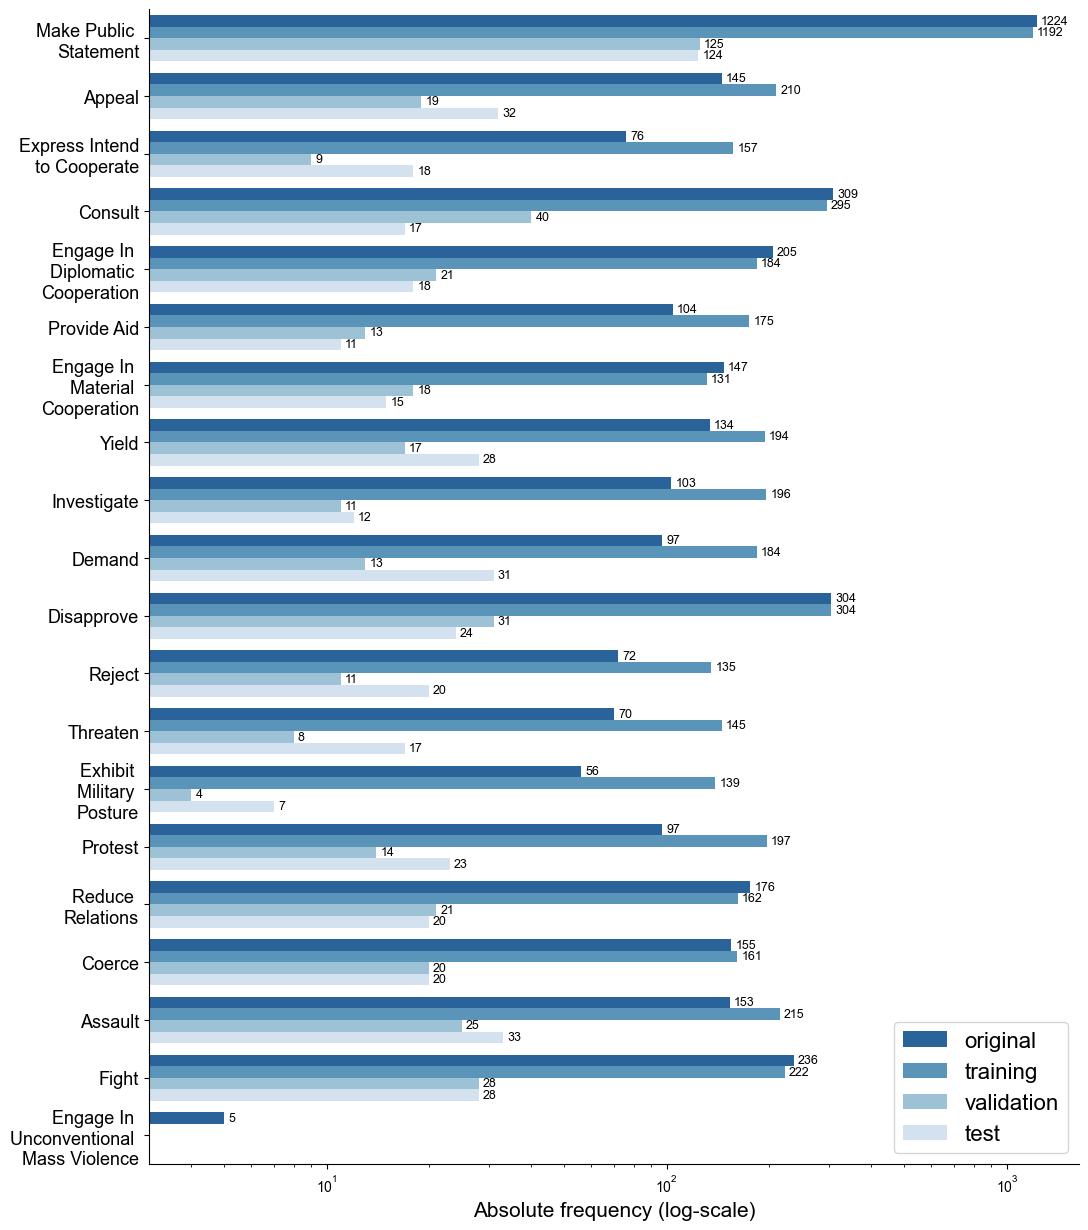

In [8]:
data = data_rdy.copy()
#extract the categorized relation from original df
data["label"] = data.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
data["label"] = data.label.apply(lambda x: x.replace("Express Intent to Cooperate", "Express Intend to Cooperate"))
relation = []
for row in data.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
data["relations"] = relation 

expl = data.explode("relations")
expl["split"] = "original"

#extract the categorized relation from split df
full_set["label"] = full_set.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in full_set.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
full_set["relations"] = relation 


expl1 = full_set.explode("relations")


all_expl = pd.concat([expl, expl1])
all_expl["relations"] = all_expl.relations.apply(lambda x: x.replace(
    "Provide Aid", "Provide Aid").replace(
    "Engage In Diplomatic Cooperation", "Engage In \nDiplomatic \nCooperation").replace(
    "Make Public Statement", "Make Public \nStatement").replace(
    "Express Intend to Cooperate","Express Intend\nto Cooperate").replace(
    "Engage In Material Cooperation", "Engage In \nMaterial \nCooperation").replace(
    "Exhibit Military Posture", "Exhibit \nMilitary \nPosture").replace(
    "Reduce Relations", "Reduce \nRelations").replace(
    "Express Intent to Cooperate","Express Intent \nto Cooperate").replace(
    "Engage in unconventional mass violence","Engage In \nUnconventional \nMass Violence"))
all_expl["sort_1"] = all_expl.relations.map(order_1)
all_expl["sort_2"] = all_expl.split.map(order_2)
expl_sorted = all_expl.sort_values(by=["sort_1","sort_2"], ascending = True)

plt.figure(figsize=(12,15))
ax = sns.countplot(y = expl_sorted.relations, hue = expl_sorted.split, palette = "Blues_r")
ax.bar_label(ax.containers[0], padding = 3, fontsize = 9)
ax.bar_label(ax.containers[1], padding = 3, fontsize = 9)
ax.bar_label(ax.containers[2], padding = 3, fontsize = 9)
ax.bar_label(ax.containers[3], padding = 3, fontsize = 9)

sns.despine()
plt.xlabel('Absolute frequency (log-scale)', fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("")
plt.yticks(fontsize = 13)
plt.xscale("log")
plt.legend(prop = {"size":16}, fontsize = 15)

df1 = pd.pivot_table(expl_sorted,
              index='relations',
              columns='split',
              aggfunc='size')

idx = df1.index.to_list()

In [9]:
#How many relations does each text have?
full_set["rel_count"] = full_set.label.apply(lambda x: x.count("<triplet>"))
for count in range(full_set.rel_count.max()):
    print(f"Count of sentences with {count + 1} relations: {full_set[full_set.rel_count == count + 1].shape[0]} ({full_set[full_set.rel_count == count + 1].shape[0] / full_set.shape[0] * 100}%)")

#all sentences have only 1 relation

Count of sentences with 1 relations: 1549 (50.75360419397117%)
Count of sentences with 2 relations: 918 (30.078636959370904%)
Count of sentences with 3 relations: 347 (11.36959370904325%)
Count of sentences with 4 relations: 130 (4.259501965923985%)
Count of sentences with 5 relations: 71 (2.326343381389253%)
Count of sentences with 6 relations: 23 (0.7536041939711665%)
Count of sentences with 7 relations: 9 (0.2948885976408912%)
Count of sentences with 8 relations: 3 (0.09829619921363039%)
Count of sentences with 9 relations: 2 (0.0655307994757536%)


In [11]:
full_set.rel_count.sum()

5544

In [10]:
full_set.shape

(3052, 5)

In [73]:
(71+23+9+3+2)

108

In [74]:
(71+23+9+3+2) / full_set.shape[0] *100

3.5386631716906947

In [54]:
relation = []
for row in train.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
train["relations"] = relation 
pct = train.explode("relations").groupby("relations").text.count().reset_index()
pct["pct"] = pct.text.apply(lambda x: x / train.explode("relations").shape[0])


In [55]:
pct

,relations,text,pct
0,Appeal,210,0.045672
1,Assault,215,0.046759
2,Coerce,161,0.035015
3,Consult,295,0.064158
4,Demand,184,0.040017
5,Disapprove,304,0.066116
6,Engage In Diplomatic Cooperation,184,0.040017
7,Engage In Material Cooperation,131,0.028491
8,Exhibit Military Posture,139,0.030231
9,Express Intend to Cooperate,157,0.034145


### Pentacode

In [56]:
cameo_to_penta = {
    "Make Public Statement" : "Make a Statement",
    "Appeal" : "Make a Statement", 
    "Express Intend to Cooperate" : "Verbal Cooperation",
    "Consult" : "Verbal Cooperation",
    "Engage In Diplomatic Cooperation" : "Verbal Cooperation",
    "Engage In Material Cooperation" : "Material Cooperation",
    "Provide Aid" : "Material Cooperation",
    "Yield" : "Material Cooperation", 
    "Investigate" : "Verbal Conflict",
    "Demand" : "Verbal Conflict",
    "Disapprove" : "Verbal Conflict",
    "Reject" : "Verbal Conflict",
    "Threaten" : "Verbal Conflict",
    "Exhibit Military Posture" : "Material Conflict",
    "Protest" : "Material Conflict", 
    "Reduce Relations" : "Verbal Conflict",
    "Coerce" : "Material Conflict",
    "Assault" : "Material Conflict",
    "Fight" : "Material Conflict",
    "Engage in unconventional mass violence" : "Material Conflict"
}

In [57]:
order_3 = {
    "Make a Statement":0,
    "Verbal Cooperation":1,
    "Material Cooperation":2,
    "Verbal Conflict":3,
    "Material Conflicht":4
}

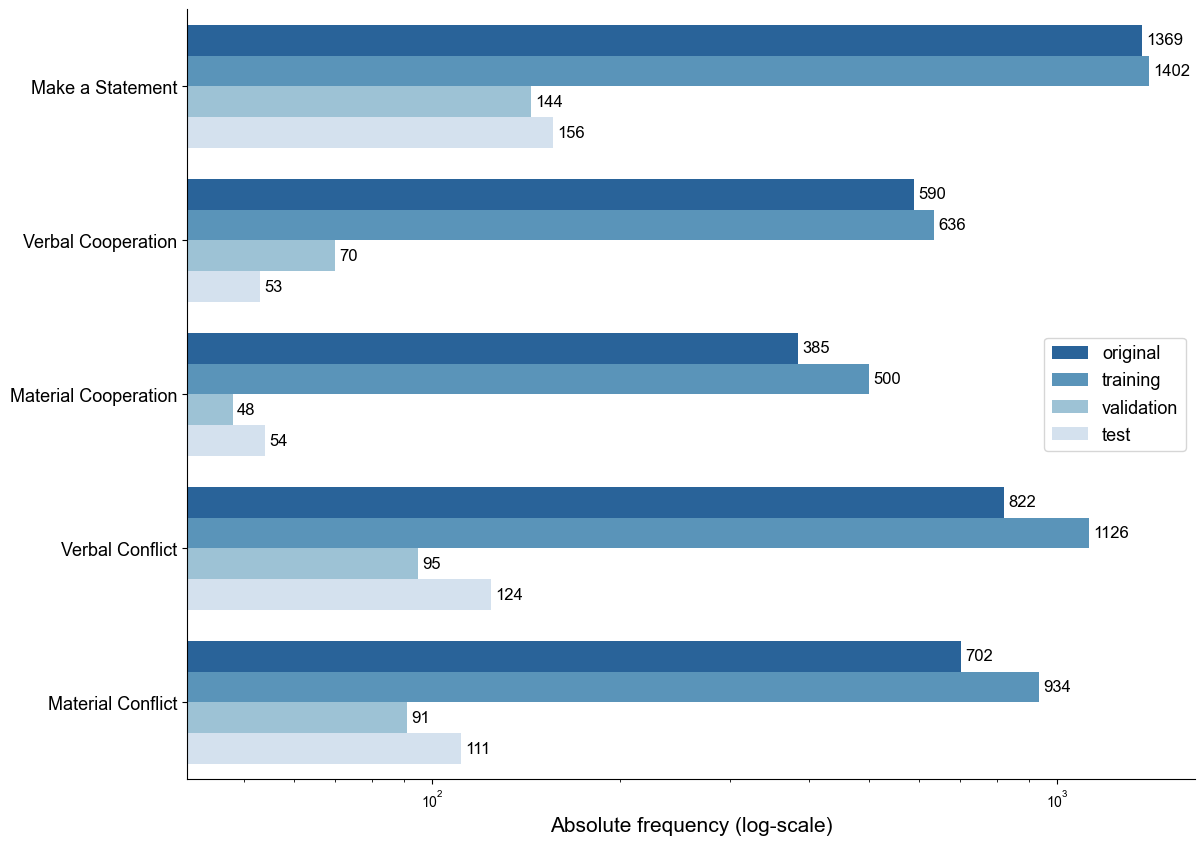

In [60]:
data = data_rdy.copy()
#extract the categorized relation from original df
data["label"] = data.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
data["label"] = data.label.apply(lambda x: x.replace("Express Intent to Cooperate", "Express Intend to Cooperate"))

penta_map = []
for row in data.iterrows():
    trip_text = row[1]["label"]
    for key in cameo_to_penta.keys():
        if key in row[1]["label"]: trip_text = trip_text.replace(key, cameo_to_penta[key])
    penta_map.append([row[1]["text"], trip_text, row[1]["split"]])
data = pd.DataFrame(penta_map, columns = ["text","label","split"])

relation = []
for row in data.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
data["relations"] = relation 

expl = data.explode("relations")
expl["split"] = "original"

#extract the categorized relation from split df
full_set["label"] = full_set.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))

penta_map = []
for row in full_set.iterrows():
    trip_text = row[1]["label"]
    for key in cameo_to_penta.keys():
        if key in row[1]["label"]: trip_text = trip_text.replace(key, cameo_to_penta[key])
    penta_map.append([row[1]["text"], trip_text, row[1]["split"]])
full_set = pd.DataFrame(penta_map, columns = ["text","label", "split"])

relation = []
for row in full_set.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
full_set["relations"] = relation 

expl1 = full_set.explode("relations")

all_expl = pd.concat([expl, expl1])

all_expl["sort_1"] = all_expl.relations.map(order_3)
all_expl["sort_2"] = all_expl.split.map(order_2)

expl_sorted = all_expl.sort_values(by=["sort_1","sort_2"], ascending = True)

plt.figure(figsize=(13,10))
ax = sns.countplot(y = expl_sorted.relations, hue = expl_sorted.split, palette = "Blues_r")
ax.bar_label(ax.containers[0], padding = 3, fontsize = 12)
ax.bar_label(ax.containers[1], padding = 3, fontsize = 12)
ax.bar_label(ax.containers[2], padding = 3, fontsize = 12)
ax.bar_label(ax.containers[3], padding = 3, fontsize = 12)

sns.despine()
plt.xlabel('Absolute frequency (log-scale)', fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("")
plt.yticks(fontsize = 13)
plt.xscale("log")
plt.legend(prop = {"size":13}, loc = "center right", fontsize = 15)

df1 = pd.pivot_table(expl_sorted,
              index='relations',
              columns='split',
              aggfunc='size')

idx = df1.index.to_list()

In [ ]:
new = []
for row in full_set.iterrows():
    sub = []
    split = re.split("<\w*>", row[1]["label"])[1:]       #first one is empty
    for i in range(int(len(split)/3)):                      #always pairs of 3
        sub_split = split[i*3:i*3+3]
        sub_split = [sub.rstrip().lstrip() for sub in sub_split]
        
        sub.append("<triplet> " + " <split> ".join(sub_split))
    sub_dedupe = list(set(sub))
    new.append(sub_dedupe)         
        
full_set["rel_sets"] = new

In [ ]:
full_set["new_count"] = full_set.rel_sets.apply(lambda x: len(x))

In [ ]:
new = []
for row in full_set.iterrows():
    label = " ".join(row[1]["rel_sets"])
    split = re.split("<\w*>", label)[1:]       #first one is empty
    new_rel = ""
    for i in range(int(len(split)/3)):                      #always pairs of 3
        sub_split = split[i*3:i*3+3]
        sub_split = [sub.rstrip().lstrip() for sub in sub_split]
        new_rel += f" <triplet> {sub_split[0]} <subj> {sub_split[1]} <obj> {sub_split[2]}"
    new.append(new_rel)    
        
full_set["label_new"] = new

In [ ]:
full_set[full_set.new_count != full_set.rel_count].iloc[0].label_new

" <triplet> Halloween crush <subj> 150 people <obj> Assault <triplet> Russian ministryRussia's Foreign Affairs Ministryn Prime Minister Han Duck-soo <subj> Halloween crush <obj> Investigate <triplet> Russian ministryRussia's Foreign Affairs Ministry <subj> Halloween crush <obj> Investigate"

In [ ]:
full_set

" <triplet> Russian ministryRussia's Foreign Affairs Ministry <subj> Halloween crush <obj> Investigate <triplet> Halloween crush <subj> 150 people <obj> Assault <triplet> Russian ministryRussia's Foreign Affairs Ministryn Prime Minister Han Duck-soo <subj> Halloween crush <obj> Investigate <triplet> Halloween crush <subj> 150 people <obj> Assault"

In [ ]:
full_set.label.iloc[200]

" <triplet> Fox News radio's Brian Kilmeade <subj> cost cutting planAnalysisCanada <obj> Make Public Statement <triplet> The International News Media Association <subj> our common European home <obj> Investigate"

In [ ]:
full_set["label"] = full_set.label_new.apply(lambda x: strip_multiple_whitespaces(x).lstrip().rstrip())

## Get samples for appendix

In [1]:
import pandas as pd

In [13]:
pd.read_csv("annotated/new_train_aug_0.csv").sample(10)[["text","label"]].to_csv("sample_train.csv")

In [11]:
pd.read_csv("unsupervised/test_0.csv").sample(10)[["text","label"]].to_csv("sample_test_unsup.csv")